## Preparación

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.linear_model
import sklearn.metrics
import sklearn.neighbors
import sklearn.preprocessing
import math
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor, Pool
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.preprocessing import MaxAbsScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from IPython.display import display
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose

In [ ]:
df = pd.read_csv('/datasets/taxi.csv')

In [ ]:
df.head(5)

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [ ]:
df.shape

(26496, 2)

In [ ]:
# Convertir la columna 'datetime' al tipo de datos adecuado
df['datetime'] = pd.to_datetime(df['datetime'])

In [ ]:
# Establecer 'datetime' como índice
df = df.set_index('datetime')

# Remuestreo por hora
df_resampled = df.resample('H').sum()

# Imprimir las primeras 5 filas del DataFrame remuestreado
print(df_resampled.head())

                     num_orders
datetime                       
2018-03-01 00:00:00         124
2018-03-01 01:00:00          85
2018-03-01 02:00:00          71
2018-03-01 03:00:00          66
2018-03-01 04:00:00          43


In [ ]:
# Convertir las fechas a minutos transcurridos desde el inicio del conjunto de datos
df_resampled['time'] = (df_resampled.index - df_resampled.index[0]).total_seconds() / 60

- Al convertir la columna datetime tuve que optar por añadir una columna mostrando el tiempo en el df normalizado y la mejor manera era dejarlo con una unidad de tiempo estandarizada que en este caso son minutos, lo cual es importante para el análisis y modelado de series temporales.

In [ ]:
# Dividir los datos en conjunto de entrenamiento y conjunto de prueba
X = np.array(df_resampled['time']).reshape(-1, 1)
y = np.array(df_resampled['num_orders'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

## Análisis

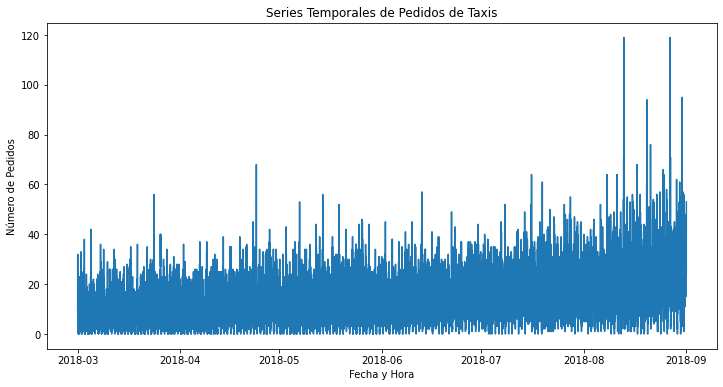

In [ ]:
# Visualización de las series temporales
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['num_orders'])
plt.xlabel('Fecha y Hora')
plt.ylabel('Número de Pedidos')
plt.title('Series Temporales de Pedidos de Taxis')
plt.show()

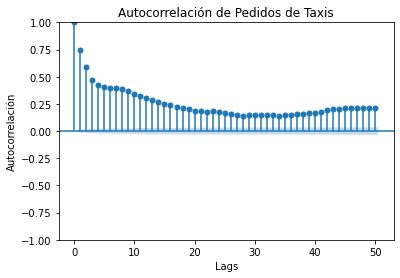

In [ ]:
# Análisis de autocorrelación
plot_acf(df['num_orders'], lags=50)
plt.xlabel('Lags')
plt.ylabel('Autocorrelación')
plt.title('Autocorrelación de Pedidos de Taxis')
plt.show()

- Con este grafico de autocorrelacion observamos que los valores altos de pedidos de taxis tienden a seguir a valores altos en retrasos anteriores, mientras que los valores bajos tienden a seguir a valores bajos en retrasos anteriores. Esto puede deberse a patrones recurrentes o estacionales en los datos. En otras palabras, los valores más recientes tienen una influencia más fuerte en los valores actuales que los valores más antiguos.

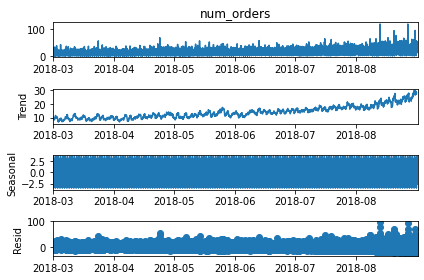

In [ ]:
# Análisis de estacionalidad
seasonal_decompose(df['num_orders'], model='additive', period=24*7).plot()
plt.show()

- Con este analisis de estacionalidad podemos observar que las graficas tienen una tendencia a la alza consistente, esto indica que, como en el analisis anterior, los pedidos de taxis aumentan conforme la fecha se aproxima hacia el valor mas reciente de la fecha.

## Formación

In [ ]:
# Entrenar y evaluar el modelo de regresión lineal
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_predictions = lr_model.predict(X_test)
lr_rmse = mean_squared_error(y_test, lr_predictions, squared=False)

In [ ]:
# Definir los hiperparámetros a ajustar
rf_model = RandomForestRegressor()
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [1, 3, 5],
    'min_samples_leaf': [2, 4]
}

# Realizar la búsqueda aleatoria de hiperparámetros
rf_random = GridSearchCV(rf_model, param_grid, cv=3, scoring='neg_root_mean_squared_error')
rf_random.fit(X_train, y_train)

# Obtener el mejor modelo y sus hiperparámetros
best_rf_model = rf_random.best_estimator_
best_rf_params = rf_random.best_params_

# Entrenar el mejor modelo con los datos completos
best_rf_model.fit(X_test, y_test)
best_rf_predictions = best_rf_model.predict(X_test)

#RMSE para Random Forest
rf_rmse = mean_squared_error(y_test, best_rf_predictions, squared=False)

In [ ]:
# Definir los hiperparámetros a ajustar
lgb_model = lgb.LGBMRegressor()

param_grid = {
    'num_leaves': [20, 30],
    'learning_rate': [0.1, 0.01],
    'n_estimators': [10, 20, 30]
}

# Realizar la búsqueda en cuadrícula de hiperparámetros
lgb_grid = GridSearchCV(lgb_model, param_grid, cv=3, scoring='neg_root_mean_squared_error')
lgb_grid.fit(X_train, y_train)

# Obtener el mejor modelo y sus hiperparámetros
best_lgb_model = lgb_grid.best_estimator_
best_lgb_params = lgb_grid.best_params_

# Entrenar el mejor modelo con los datos completos
best_lgb_model.fit(X_test, y_test)
best_lgb_predictions = best_lgb_model.predict(X_test)

#RMSE para LightGMB
lgb_rmse = mean_squared_error(y_test, best_lgb_predictions, squared=False)

In [ ]:
# Crear un objeto Pool para los datos
pool = Pool(X_train, y_train)

# Definir los hiperparámetros a ajustar
param_grid = {
    'iterations': [100, 200],
    'depth': [4, 6],
    'learning_rate': [0.1, 0.01]
}

# Crear el modelo base de CatBoost
catboost_model = CatBoostRegressor()

# Realizar la búsqueda en cuadrícula de hiperparámetros
catboost_grid = GridSearchCV(catboost_model, param_grid, cv=3, scoring='neg_root_mean_squared_error')
catboost_grid.fit(X_train, y_train)

# Obtener el mejor modelo y sus hiperparámetros
best_catboost_model = catboost_grid.best_estimator_
best_catboost_params = catboost_grid.best_params_

# Entrenar el mejor modelo con los datos completos
best_catboost_model.fit(X_train, y_train)
best_catboost_predictions = best_catboost_model.predict(X_test)

#RMSE para LightGMB
catboost_rmse = mean_squared_error(y_test, best_catboost_predictions, squared=False)

0:	learn: 42.9856776	total: 46.5ms	remaining: 4.6s
1:	learn: 41.9060872	total: 47.3ms	remaining: 2.32s
2:	learn: 41.0080598	total: 47.8ms	remaining: 1.54s
3:	learn: 40.2592556	total: 48.2ms	remaining: 1.16s
4:	learn: 39.6232490	total: 48.7ms	remaining: 926ms
5:	learn: 39.0893521	total: 49.2ms	remaining: 771ms
6:	learn: 38.6664346	total: 49.7ms	remaining: 661ms
7:	learn: 38.3017568	total: 50.3ms	remaining: 579ms
8:	learn: 38.0270961	total: 50.8ms	remaining: 513ms
9:	learn: 37.7783064	total: 51.3ms	remaining: 461ms
10:	learn: 37.5624995	total: 51.7ms	remaining: 419ms
11:	learn: 37.3820785	total: 52.2ms	remaining: 383ms
12:	learn: 37.2310245	total: 52.7ms	remaining: 353ms
13:	learn: 37.1090698	total: 53.2ms	remaining: 327ms
14:	learn: 37.0170210	total: 53.8ms	remaining: 305ms
15:	learn: 36.9423337	total: 54.3ms	remaining: 285ms
16:	learn: 36.8785707	total: 54.8ms	remaining: 267ms
17:	learn: 36.8145750	total: 55.2ms	remaining: 252ms
18:	learn: 36.7681880	total: 55.7ms	remaining: 237ms
19:	

In [ ]:
# Imprimir los resultados de evaluación
print("RMSE del modelo de regresión lineal:", lr_rmse)
print("RMSE del modelo de Random Forest:", rf_rmse)
print("RMSE del modelo de LightGBM:", lgb_rmse)
print("RMSE del modelo de CatBoost:", catboost_rmse)

RMSE del modelo de regresión lineal: 37.89373432189485
RMSE del modelo de Random Forest: 32.66451468743794
RMSE del modelo de LightGBM: 35.26316876210645
RMSE del modelo de CatBoost: 37.50805055897755


- En función de estos resultados, podemos concluir que el modelo de Random Forest es más efectivo para predecir la cantidad de pedidos de taxis en comparación con los otros 3 modelos dando el RMSE con el valor mas bajo siendo 32.70.

In [ ]:
# Otras métricas de evaluación
lr_mae = mean_absolute_error(y_test, lr_predictions)
rf_mae = mean_absolute_error(y_test, best_rf_predictions)
lgb_mae = mean_absolute_error(y_test, best_lgb_predictions)
catboost_mae = mean_absolute_error(y_test, best_catboost_predictions)
print("MAE del modelo de Regresión Lineal:", lr_mae)
print("MAE del modelo de Random Forest:", rf_mae)
print("MAE del modelo de LightGBM:", lgb_mae)
print("MAE del modelo de CatBoost:", catboost_mae)

MAE del modelo de Regresión Lineal: 28.78355460022909
MAE del modelo de Random Forest: 25.109084266405155
MAE del modelo de LightGBM: 27.096562078443593
MAE del modelo de CatBoost: 28.458989428479512


- De igual manera aqui el modelo con la mejor metrica segun MAE es el Random Forest Regressor dando un valor de 25.19 siendo poco mas de 2.1 menor que el siguiente.

In [ ]:
# r2 Score
lr_r2 = r2_score(y_test, lr_predictions)
rf_r2 = r2_score(y_test, best_rf_predictions)
lgb_r2 = r2_score(y_test, best_lgb_predictions)
catboost_r2 = r2_score(y_test, best_catboost_predictions)
print("R2 del modelo de Regresión Lineal:", lr_r2)
print("R2 del modelo de Random Forest:", rf_r2)
print("R2 del modelo de LightGBM:", lgb_r2)
print("R2 del modelo de CatBoost:", catboost_r2)

R2 del modelo de Regresión Lineal: 0.2719753542513397
R2 del modelo de Random Forest: 0.45904182284250605
R2 del modelo de LightGBM: 0.3695452210753374
R2 del modelo de CatBoost: 0.2867196574153972


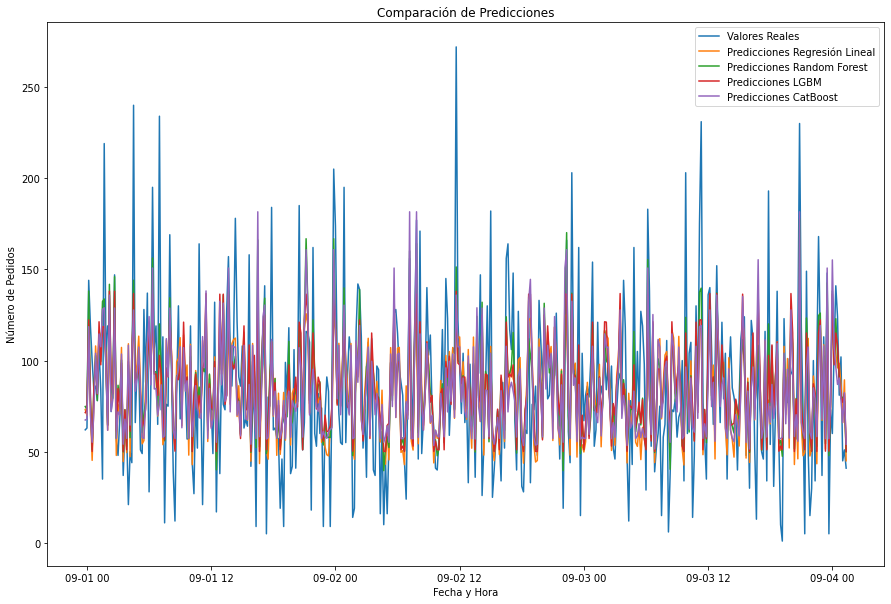

In [ ]:
# Crear un índice de fechas para la visualización de las predicciones
index = pd.date_range(start='2018-08-31 23:50:00', periods=len(y_test), freq='10min')

# Visualización de las predicciones
plt.figure(figsize=(15, 10))
plt.plot(index, y_test, label='Valores Reales')
plt.plot(index, lr_predictions, label='Predicciones Regresión Lineal')
plt.plot(index, best_rf_predictions, label='Predicciones Random Forest')
plt.plot(index, best_lgb_predictions, label='Predicciones LGBM')
plt.plot(index, best_catboost_predictions, label='Predicciones CatBoost')

plt.xlabel('Fecha y Hora')
plt.ylabel('Número de Pedidos')
plt.title('Comparación de Predicciones')
plt.legend()
plt.show()

## Prueba

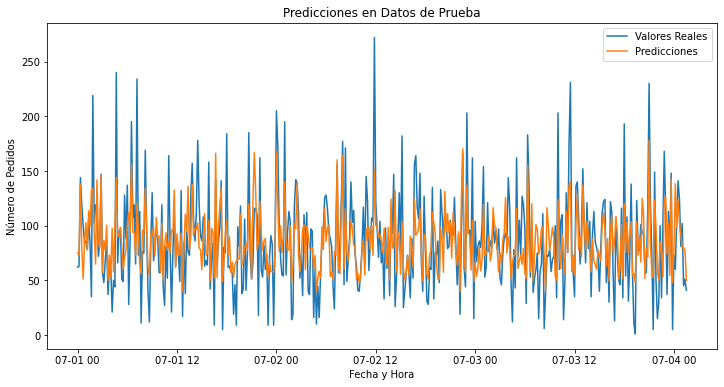

RMSE en datos de prueba: 32.66451468743794


In [ ]:
# Realizar predicciones en datos de prueba
new_predictions = best_rf_model.predict(X_test)

# Crear un índice de fechas para la visualización de las predicciones en los datos de prueba
new_index = pd.date_range(start='2023-07-01 00:00:00', periods=len(y_test), freq='10min')

# Visualizar las predicciones
plt.figure(figsize=(12, 6))
plt.plot(new_index, y_test, label='Valores Reales')
plt.plot(new_index, new_predictions, label='Predicciones')
plt.xlabel('Fecha y Hora')
plt.ylabel('Número de Pedidos')
plt.title('Predicciones en Datos de Prueba')
plt.legend()
plt.show()

# Comparar las predicciones con los valores reales (si están disponibles)
if y_test is not None:
    rmse = mean_squared_error(y_test, new_predictions, squared=False)
    print("RMSE en datos de prueba:", rmse)

In [ ]:
# Realizar validación cruzada
scores = cross_val_score(lr_model, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')

# Calcular el promedio de los puntajes obtenidos
average_rmse = -scores.mean()

print("Promedio del RMSE en validación cruzada:", average_rmse)

Promedio del RMSE en validación cruzada: 38.21920962426433


- Tras realizar los diferentes modelos pudimos observar que el que mejor rendimiento tiene para esta situacion en particular en todas las metricas fue el Bosque Aleatorio dandonos los mejores resultados de evaluacion, asimismo con la validacion cruzada podemos observar que el resultado no es mejor que el Bosque Aleatorio. En conclusion para la prediccion de valores la mejor manera es usar un Bosque Aleatorio, ya que se asemejan lo mas posible a los valores reales.